In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 23a

##  Convolutional Neural Network (CNN)
- Fashion MNIST
- Dataset From CSV File

<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
### Import Libraries

import tensorflow as tf

import os

#import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

2022-12-14 19:46:57.630266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 19:46:57.772715: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-14 19:46:57.777894: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-14 19:46:57.777908: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
tf.__version__

'2.10.0'

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
%matplotlib inline

2022-12-14 19:47:00.240165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-14 19:47:00.240220: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 19:47:00.240260: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dai-Precision-7820-Tower): /proc/driver/nvidia/version does not exist


In [5]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 108 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 20 # number of cycles to run


BATCH_SIZE = 16 # inline of Traing Rows being 60000

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.winter

plt.rcParams.update(params) # update rcParams

## Helper Function

In [6]:
def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[1].capitalize())
    ax.grid();
    plt.tight_layout()

In [7]:
def fn_plot_label(train_df, test_df):
    
    plt.figure(figsize = (15,5))
    
    plt.subplot(1,2,1)

    ax = train_df['label'].value_counts().plot(kind='bar',
                                               title="Training distribution",
                                               color = 'DarkBlue', alpha = 0.8)


    plt.subplot(1,2,2)
    
    ax = test_df['label'].value_counts().plot(kind='bar',
                                              title="Testing distribution",
                                              color = 'Orange', alpha = 0.8)

## Using MNIST Fashion data

### Labels

Total : 785 columns
First column is label remaining columns are pixel values of the images.

Each training and test example is assigned to one of the following labels:


|Label| Class
|:-|:-|
0 | T-shirt/top
1 | Trouser
2 | Pullover
3 | Dress
4 | Coat
5 | Sandal
6 | Shirt
7 | Sneaker
8 | Bag
9 | Ankle boot

In [8]:
class_labels ={0 : 'T-shirt/top',
               1 : 'Trouser',
               2 : 'Pullover',
               3 : 'Dress',
               4 : 'Coat',
               5 : 'Sandal',
               6 : 'Shirt',
               7 : 'Sneaker',
               8 : 'Bag',
               9 : 'Ankle boot'
              }

In [9]:
train_df = pd.read_csv('/home/dai/Desktop/AI_220940128008/04 Deep_Learning/input/fashion_mnist/fashion-mnist_train.csv')
test_df = pd.read_csv('/home/dai/Desktop/AI_220940128008/04 Deep_Learning/input/fashion_mnist/fashion-mnist_test.csv')

In [10]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
train_df.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59999,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


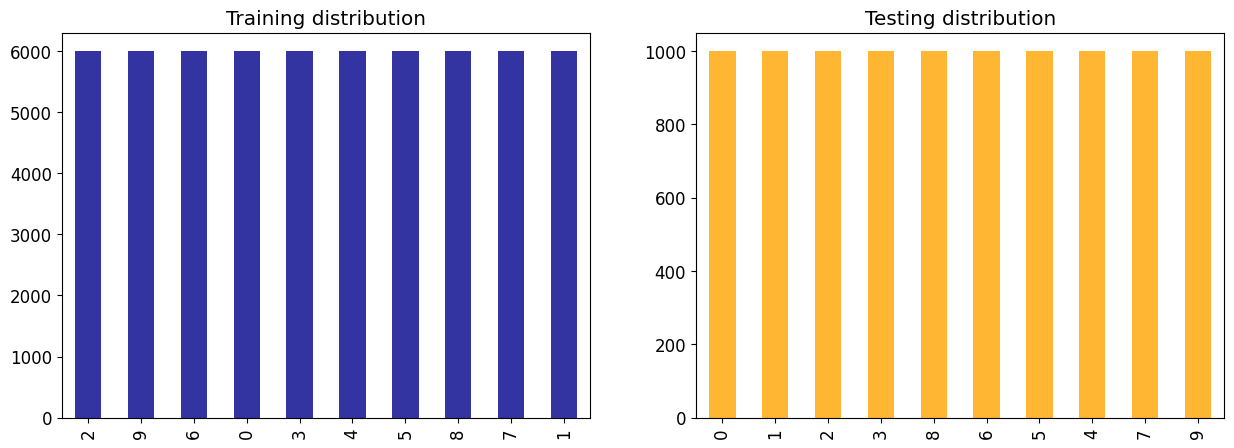

In [13]:
fn_plot_label(train_df, test_df)

## Converting to Datasets

In [14]:
def fn_split_feature_label(row):

    features = tf.reshape(row[1:] ,  [28, 28, 1 ]  )   ## Ignores Col description labels, converts rest to given dimensions

    labels = row[0]

    return features, labels

In [15]:
## Creatng the Train Dataset

temp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = temp_ds.map(fn_split_feature_label) ##Splits the features, labels

train_ds = train_ds.batch(BATCH_SIZE)  ##Creates batches

2022-12-14 19:47:05.548550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
## Creatng the Test Dataset

temp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = temp_ds.map(fn_split_feature_label) ##Splits the features, labels

test_ds = test_ds.batch(BATCH_SIZE)  ##Creates batches

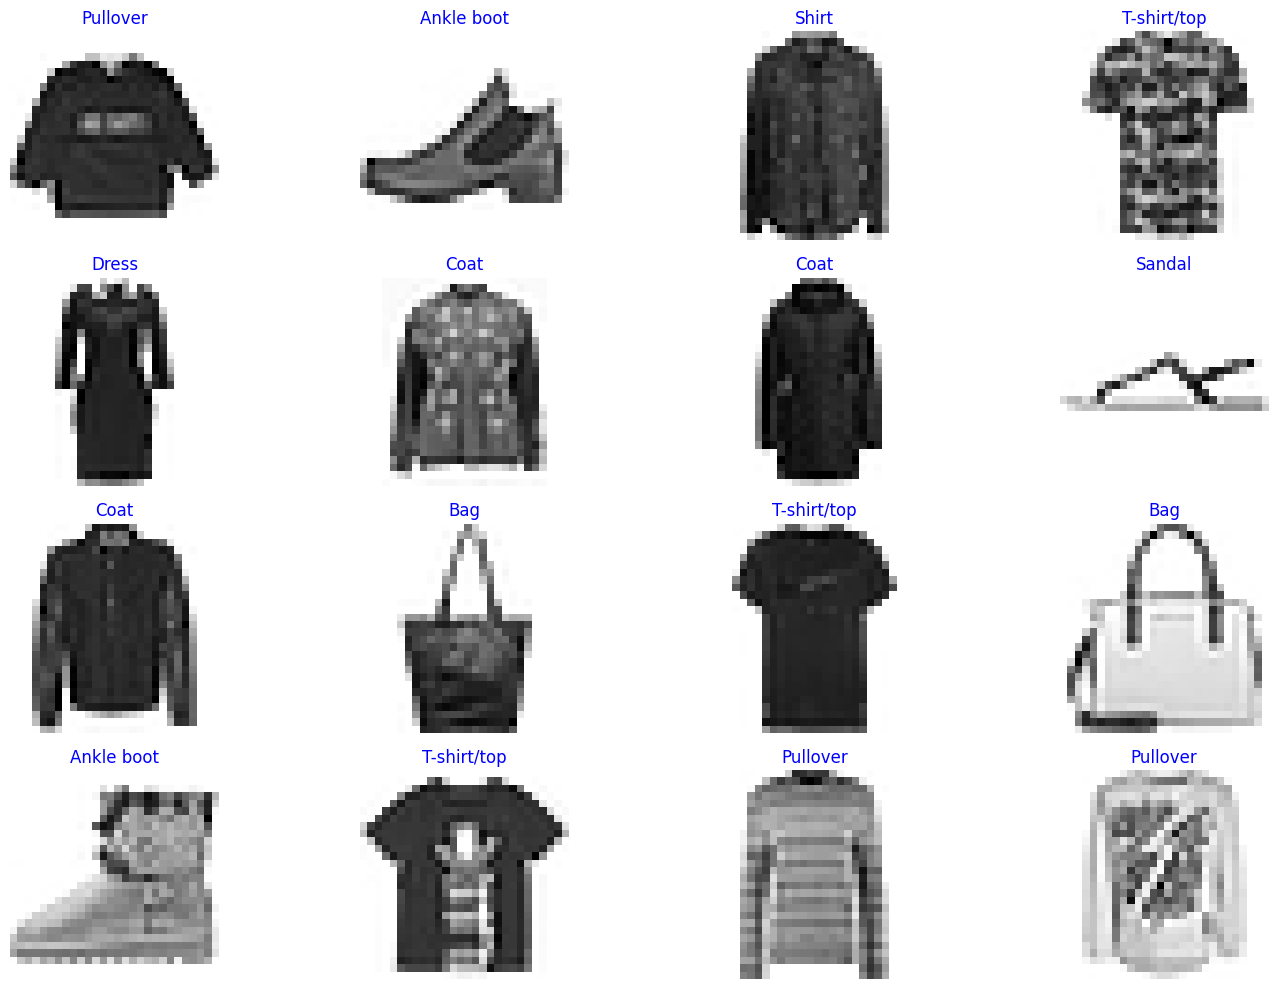

In [17]:
for images, labels in train_ds.take(1):                 ## for train
    
    for i in range(BATCH_SIZE):
        
        rws = 4 #Rows in image output
        
        plt.subplot( rws, int(BATCH_SIZE/rws), i+1)    ##Calculating Subplots

        plt.grid(False)

        plt.imshow( images[i].numpy().astype("uint8") ,   cmap=plt.cm.binary)  ##Plotting image by converting Tensor
        
        plt.title( class_labels[labels[i].numpy()], 
                  color='b', fontsize=12 )
        
        plt.axis('off')

    plt.tight_layout()

plt.show()

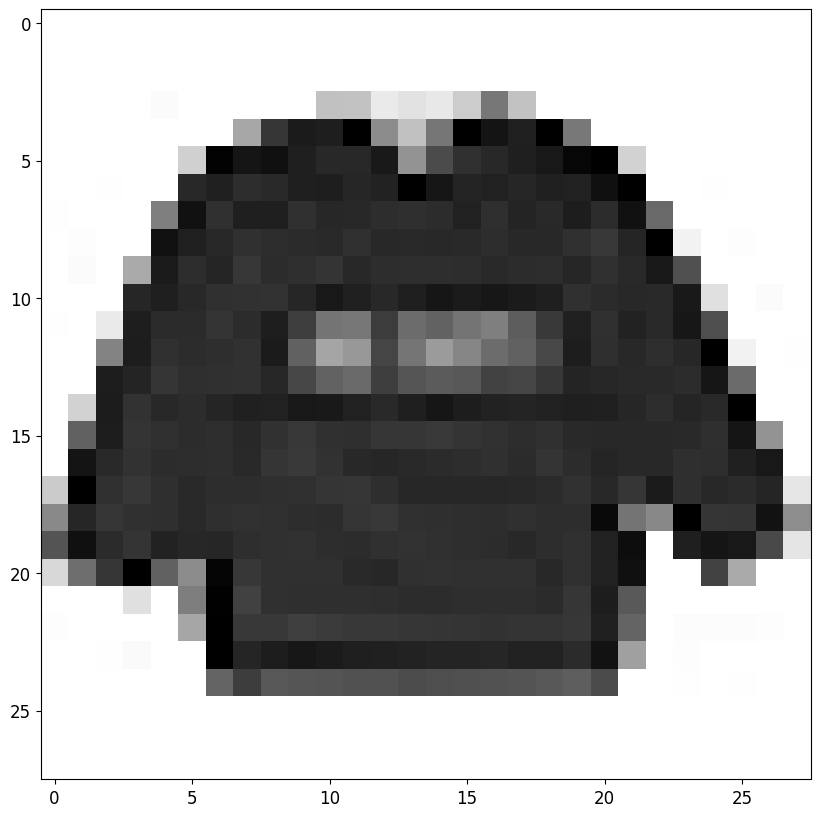

In [18]:
plt.imshow(images[0].numpy(), cmap = plt.cm.binary)

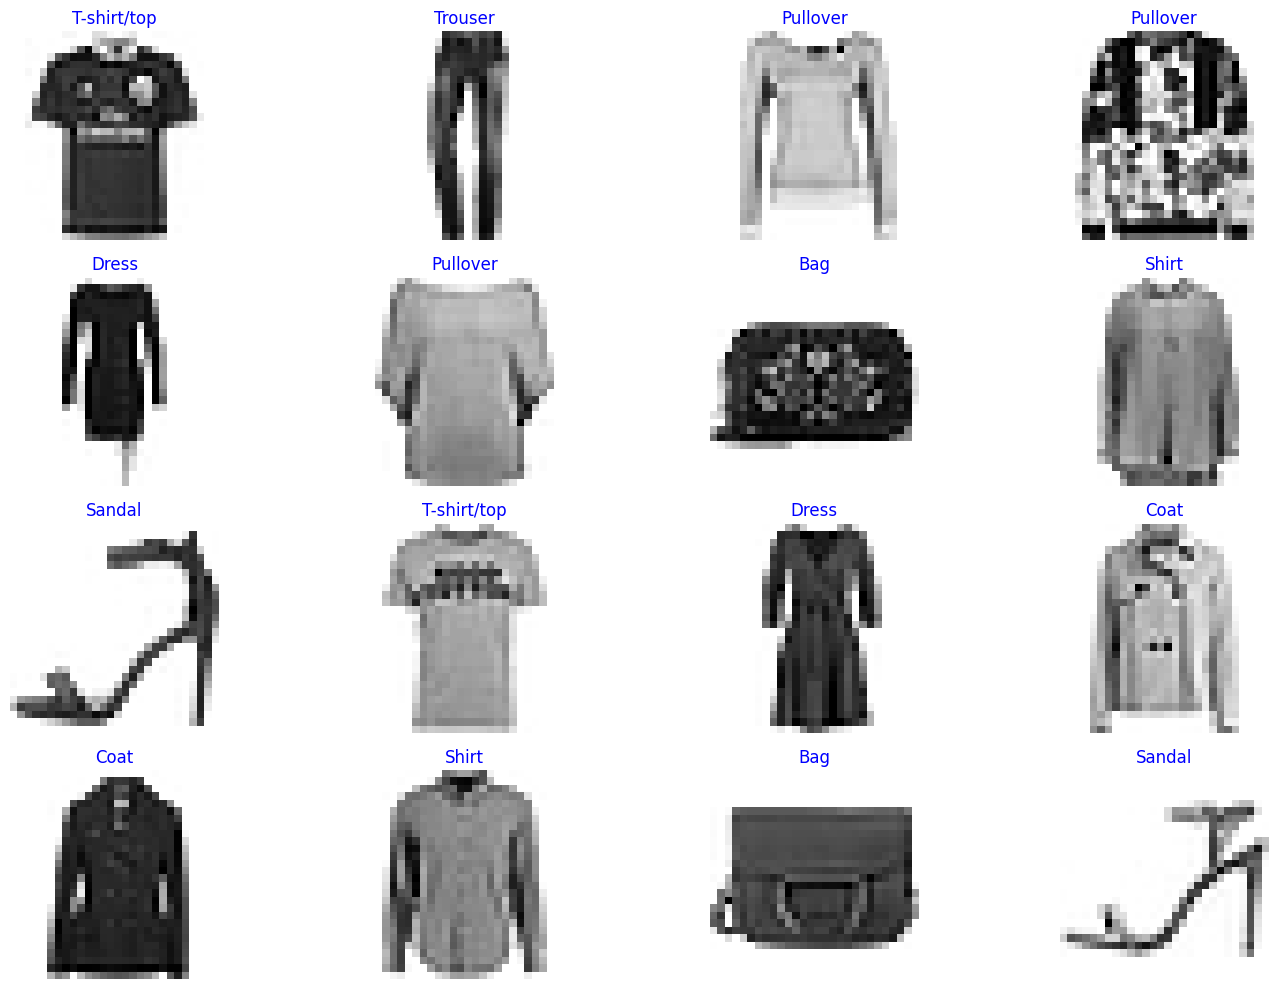

In [19]:
for images, labels in test_ds.take(1):                 ## for test
    
    for i in range(BATCH_SIZE):
        
        rws = 4 #Rows in image output
        
        plt.subplot( rws, int(BATCH_SIZE/rws), i+1)    ##Calculating Subplots

        plt.grid(False)

        plt.imshow( images[i].numpy().astype("uint8") , 
                   cmap=plt.cm.binary)  ##Plotting image by converting Tensor
        
        plt.title( class_labels[labels[i].numpy()], 
                  color='b', fontsize=12 )
        
        plt.axis('off')

    plt.tight_layout()

plt.show()

In [20]:
norm_layer = tf.keras.layers.Rescaling( 1. / 255. )

image_batch, labels_batch = next(iter(train_ds))

img = image_batch[0].numpy()

img.max(), img.min()

(255, 0)

In [21]:
norm_ds = train_ds.map(lambda x, y : (norm_layer(x), y ))

image_batch, labels_batch = next(iter(norm_ds))

img = image_batch[0].numpy()

img.max(), img.min()

(1.0, 0.0)

In [22]:
train_ds = train_ds.cache().prefetch(buffer_size= tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size= tf.data.AUTOTUNE)

## Example of Convolution, Pooling

In [23]:
input_shape = (1, 6, 6, 1)

x = tf.random.normal(input_shape)

x.shape

TensorShape([1, 6, 6, 1])

<AxesSubplot: >

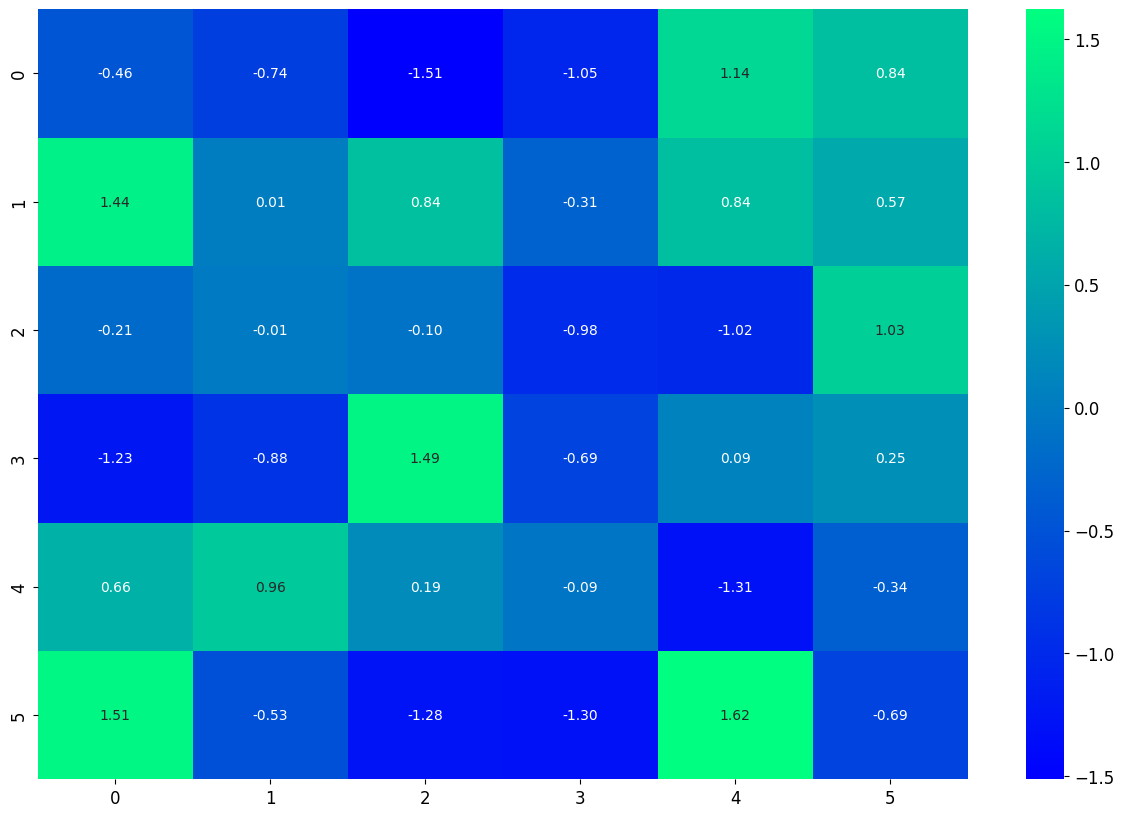

In [24]:
sns.heatmap(x.numpy()[0, :, :, 0], annot = True, fmt = '.2f' ,cmap= CMAP)

In [25]:
y = tf.keras.layers.Conv2D(1, 3, 
                         kernel_initializer=tf.constant_initializer(1.),  
                         activation='relu',
                         input_shape=input_shape[1:] ) (x)

y.shape

TensorShape([1, 4, 4, 1])

<AxesSubplot: >

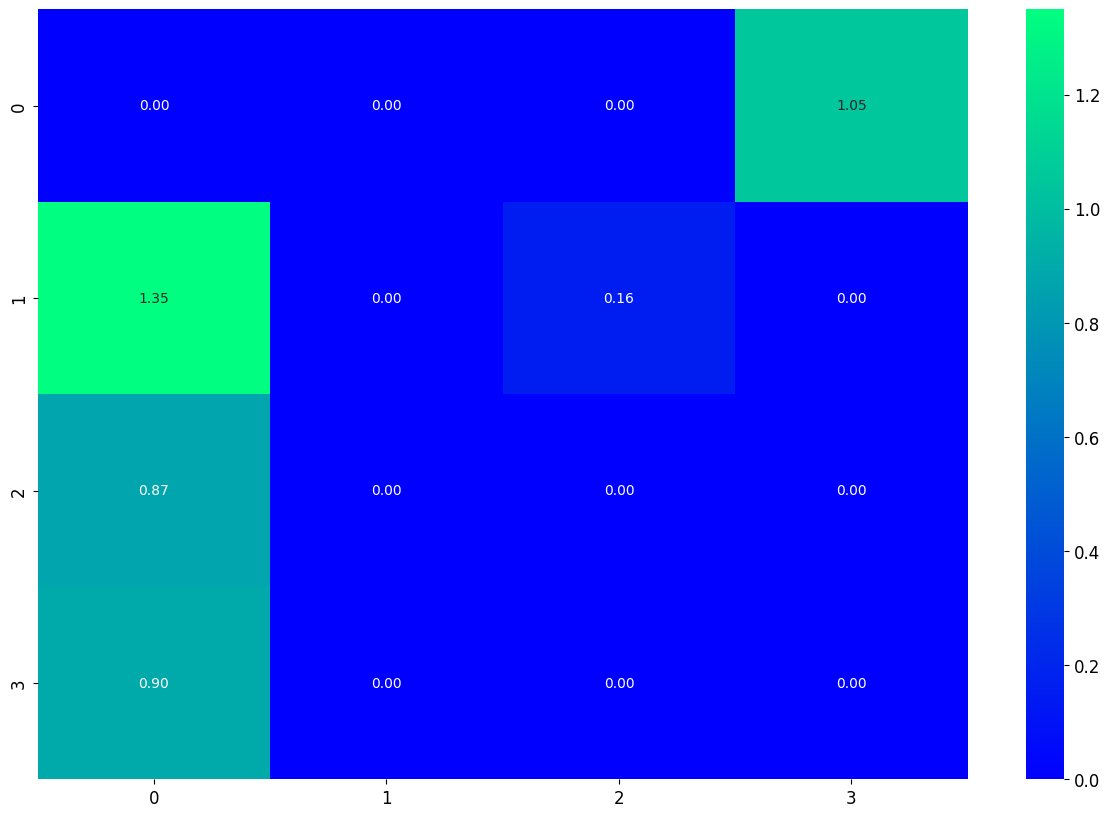

In [26]:
sns.heatmap(y.numpy()[0, :, :, 0], annot = True, fmt = '.2f' ,cmap= CMAP)

In [27]:
max_pool_2d = tf.keras.layers.MaxPooling2D( pool_size = (2, 2), strides = (2, 2),
                                           padding='valid')

z = max_pool_2d(y)

z.shape

TensorShape([1, 2, 2, 1])

<AxesSubplot: >

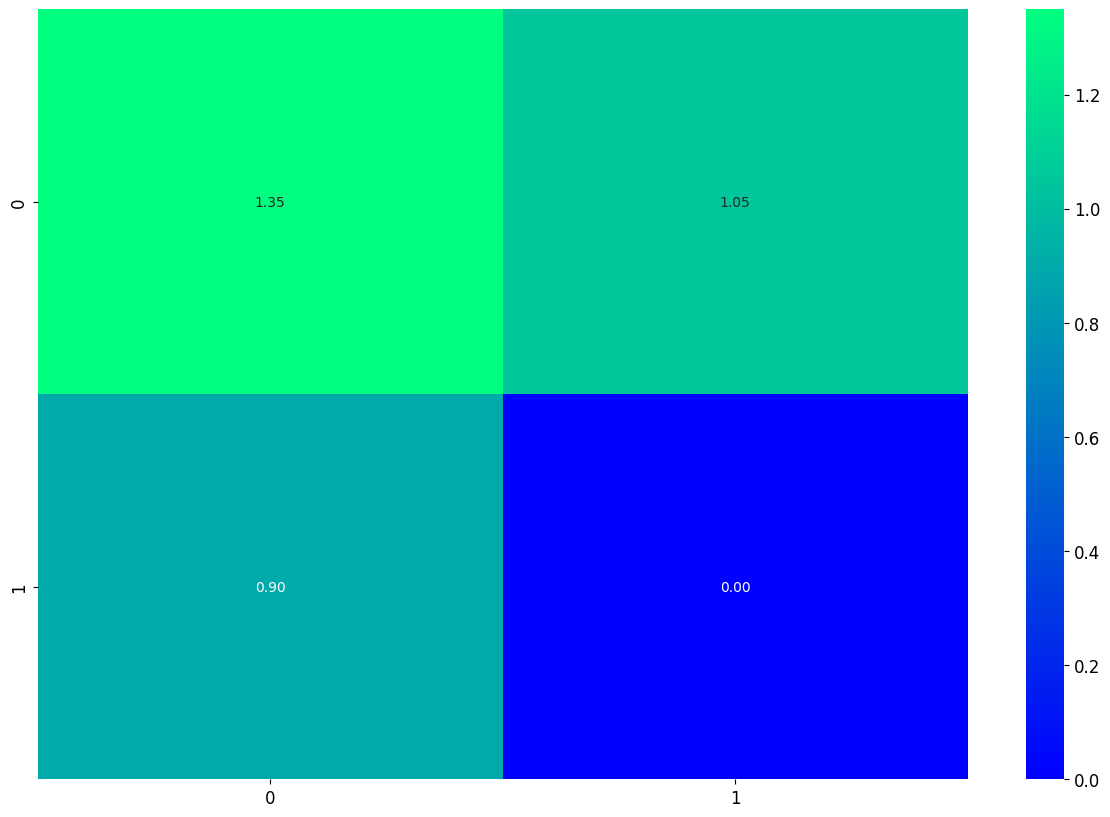

In [28]:
sns.heatmap(z.numpy()[0, :, :, 0], annot = True, fmt = '.2f' ,cmap= CMAP)

# Actual Convolution

In [29]:
kernel_init = tf.keras.initializers.GlorotUniform( seed = RANDOM_STATE)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Rescaling(1. / 255.))

##Convolution1
model.add(tf.keras.layers.Conv2D( 32, (3, 3),
                                 kernel_initializer=kernel_init,
                                 padding='same',
                                 activation='relu',
                                 input_shape= ( 28, 28, 1 ) ) ) ## 28 x 28

##Pool1
model.add(tf.keras.layers.MaxPool2D( (2, 2) ) ) ##14 x 14

##Convolution2
model.add(tf.keras.layers.Conv2D( 64, (3, 3),
                                 kernel_initializer=kernel_init,
                                 activation='relu', ) ) ## 12 x 12

##Pool2
model.add(tf.keras.layers.MaxPool2D( (2, 2) ) ) ##6 x 6

##Convolution3
model.add(tf.keras.layers.Conv2D( 128, (3, 3),
                                 kernel_initializer=kernel_init,
                                 activation='relu', ) ) ## 4 x 4

In [30]:
model.add(tf.keras.layers.Flatten() ) ##2048 Nodes

##Dense 1
model.add(tf.keras.layers.Dense( 64, 
                                kernel_initializer= kernel_init, 
                                activation = 'relu' ))

##Dense 2
model.add(tf.keras.layers.Dense( 10, 
                                kernel_initializer= kernel_init,  ))

In [31]:
model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[ 'accuracy' ])

history = model.fit(train_ds,
                    epochs=EPOCHS, 
                    validation_data=test_ds,
                    batch_size=BATCH_SIZE,)

Epoch 1/20
3750/3750 [==============================] - 54s 14ms/step - loss: 0.4209 - accuracy: 0.8454 - val_loss: 0.2989 - val_accuracy: 0.8908
Epoch 2/20
3750/3750 [==============================] - 52s 14ms/step - loss: 0.2768 - accuracy: 0.8996 - val_loss: 0.2651 - val_accuracy: 0.9059
Epoch 3/20
3750/3750 [==============================] - 51s 14ms/step - loss: 0.2303 - accuracy: 0.9150 - val_loss: 0.2486 - val_accuracy: 0.9136
Epoch 4/20
3750/3750 [==============================] - 52s 14ms/step - loss: 0.1954 - accuracy: 0.9277 - val_loss: 0.2462 - val_accuracy: 0.9152
Epoch 5/20
3750/3750 [==============================] - 51s 14ms/step - loss: 0.1675 - accuracy: 0.9389 - val_loss: 0.2623 - val_accuracy: 0.9138
Epoch 6/20
3750/3750 [==============================] - 51s 14ms/step - loss: 0.1455 - accuracy: 0.9460 - val_loss: 0.2877 - val_accuracy: 0.9118
Epoch 7/20
3750/3750 [==============================] - 51s 14ms/step - loss: 0.1280 - accuracy: 0.9515 - val_loss: 0.2948 -

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         7